In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataloader
import seq2seq
from seq2seq.models import AttentionSeq2Seq, SimpleSeq2Seq, Seq2Seq
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Bidirectional
from keras.utils import np_utils
from keras.layers import CuDNNLSTM, LSTM, LeakyReLU, CuDNNGRU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import L1L2
from keras.utils.vis_utils import plot_model
import keras.backend as K
import importlib
importlib.reload(dataloader)
%matplotlib inline


input_seq_length = 42 #288
output_seq_length = 6
dataloader.INPUT_SEQ_LENGTH = input_seq_length
dataloader.OUTPUT_SEQ_LENGTH = output_seq_length
dataloader.USE_TWITTER = True
dataloader.USE_BLOCKCHAIN = True
dataloader.TARGET_VARIABLE = 'btc_close'
X_train, Y_train, X_test, Y_test = dataloader.generate_data_keras(input_seq_length, output_seq_length,step_size=1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
in_dim = X_train.shape[2] # 17
in_len = X_train.shape[1] # 288
out_dim = Y_train.shape[2] # 1
out_len = Y_train.shape[1] # 48
units = 128
second_units = 96
batch_size = 64
epochs = 25

print(in_dim, in_len, out_dim, out_len, batch_size, epochs)

Y_train = Y_train.reshape(-1, out_len)
Y_test = Y_test.reshape(-1, out_len)

def pct_values(x, y):
    print(x.shape)
    print(y.shape)
    for i in range(x.shape[0]):
        last_price = x[i, -1, 0]
        tail = y[i,:]
        inserted = np.insert(tail, 0, last_price, axis=0)
        diff = np.diff(inserted)/inserted[1:]
        y[i,:] = diff
        
def inverse_pct(last_price, predicted):
    final = np.array([last_price])
    for i, x in enumerate(predicted):
        final = np.append(final, final[i] + final[i]*x)
    return final

pct = False
if pct:
    print('pct enabled')
    pct_values(X_test, Y_test)
    pct_values(X_train, Y_train)

(4692, 42, 50) (4692, 6, 1)
(685, 42, 50) (685, 6, 1)
50 42 1 6 64 25


In [91]:
def custom_mse(y_true, y_pred):
    scale_ = dataloader.scaler.scale_[0]
    min_ = dataloader.scaler.min_[0]
    y_pred -= min_
    y_true -= min_
    y_pred /= scale_
    y_true -= scale_
    #dataloader.denormalize_1d(y_true, dataloader.scaler.min_[0], dataloader.scaler.scale_[0])
    #dataloader.denormalize_1d(y_pred, dataloader.scaler.min_[0], dataloader.scaler.scale_[0])
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [2]:
#model 1
model = Sequential()
model.add(CuDNNGRU(units=units, input_shape=(in_len,in_dim), return_sequences=False))
                   #kernel_regularizer=L1L2(l1=0.01,l2=0.01)))
model.add(Dropout(0.5))
model.add(Dense(out_len))
#model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam')
model.summary()
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 256)               218880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
Total params: 225,048
Trainable params: 225,048
Non-trainable params: 0
_________________________________________________________________


In [4]:
#model 1 - bidirectional
model = Sequential()
model.add(Bidirectional(CuDNNGRU(units=units, return_sequences=False), input_shape=(in_len,in_dim),))
model.add(Dropout(0.5))
model.add(Dense(out_len))
#model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam')
model.summary()
#plot_model(model, to_file='model_1_bidirectional.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 512)               437760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                12312     
Total params: 450,072
Trainable params: 450,072
Non-trainable params: 0
_________________________________________________________________


In [13]:
#model 2
model = Sequential()
model.add(CuDNNGRU(units=units, input_shape=(in_len,in_dim), return_sequences=True))
model.add(Dropout(0.25))
model.add(CuDNNGRU(units=units, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(out_len))
model.compile(loss='mse', optimizer='adam')
model.summary()
#plot_model(model, to_file='model_2_july.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_5 (CuDNNGRU)       (None, 42, 128)           69120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 128)           0         
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 168,966
Trainable params: 168,966
Non-trainable params: 0
_________________________________________________________________


In [14]:
#output_file_name = 'nn_models/keras/gru-july'
model.fit(
    X_train, 
    Y_train, 
    batch_size=batch_size,
    validation_split=0.2,
    #validation_data=(validation_datas,validation_labels), 
    epochs=epochs,
    verbose=1,
    callbacks=[])

Train on 3753 samples, validate on 939 samples
Epoch 1/25
3753/3753 [==============================] - 3s 710us/step - loss: 0.0034 - val_loss: 0.0148
Epoch 2/25
3753/3753 [==============================] - 1s 268us/step - loss: 7.0560e-04 - val_loss: 0.0084
Epoch 3/25
3753/3753 [==============================] - 1s 269us/step - loss: 4.2569e-04 - val_loss: 0.0074
Epoch 4/25
3753/3753 [==============================] - 1s 268us/step - loss: 3.1750e-04 - val_loss: 0.0058
Epoch 5/25
3753/3753 [==============================] - 1s 268us/step - loss: 2.6001e-04 - val_loss: 0.0051
Epoch 6/25
3753/3753 [==============================] - 1s 270us/step - loss: 2.1040e-04 - val_loss: 0.0047
Epoch 7/25
3753/3753 [==============================] - 1s 269us/step - loss: 1.9069e-04 - val_loss: 0.0035
Epoch 8/25
3753/3753 [==============================] - 1s 269us/step - loss: 1.6847e-04 - val_loss: 0.0031
Epoch 9/25
3753/3753 [==============================] - 1s 273us/step - loss: 1.5209e-04 - va

In [9]:
import importlib
importlib.reload(dataloader)

<module 'dataloader' from 'C:\\Users\\deyan\\tf-workspace\\siap\\crypto-predictor\\dataloader.py'>

Let's visualize 5 predictions with our signals:
(5, 42, 50) (5, 6, 1)
5/5 [==============================] - 0s 65ms/step
outputs_shape (5, 6)
Test mse is:  135760.85513995777
(42,) (6,) (6,)


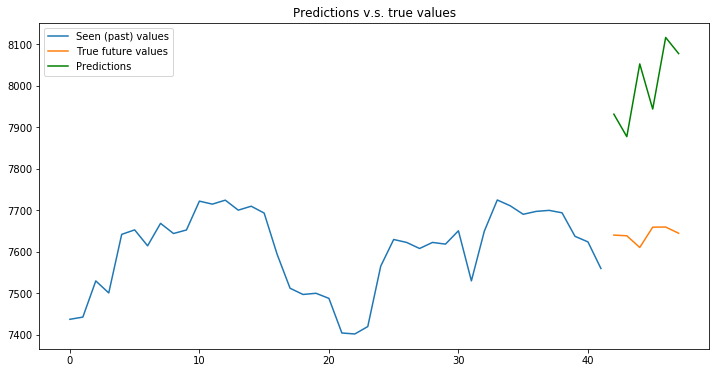

Test mse is:  47776.146888372255
(42,) (6,) (6,)


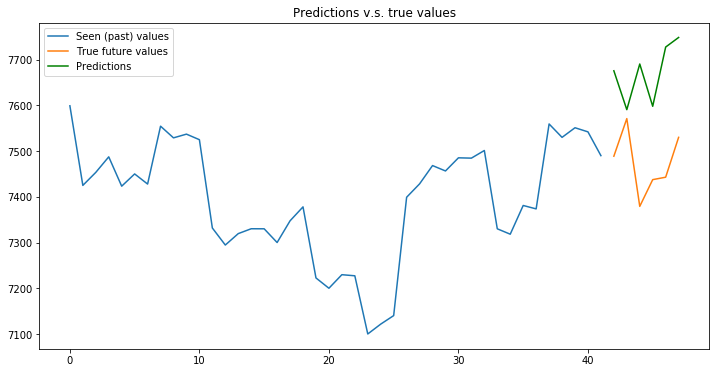

Test mse is:  31865.79023916241
(42,) (6,) (6,)


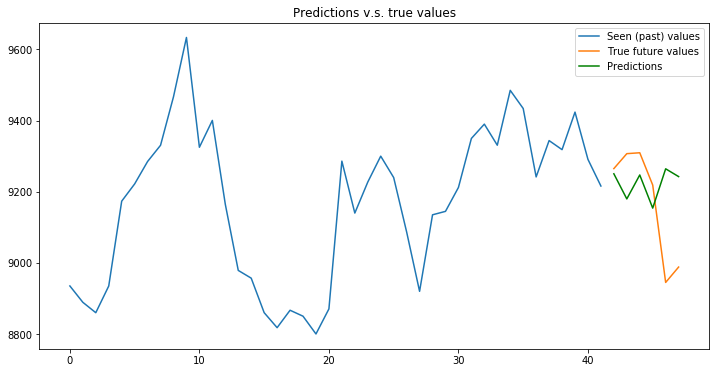

Test mse is:  31542.779341113794
(42,) (6,) (6,)


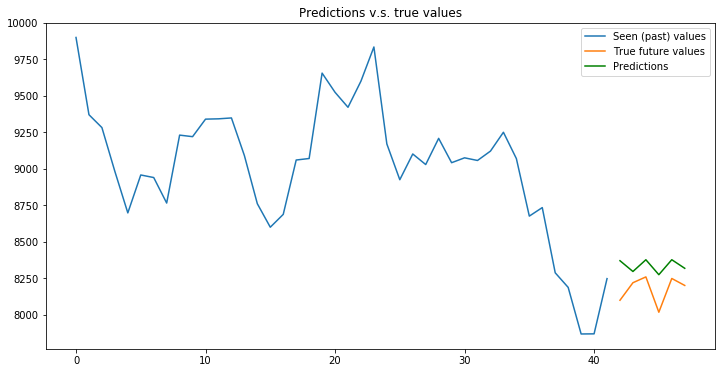

Test mse is:  60312.13574900083
(42,) (6,) (6,)


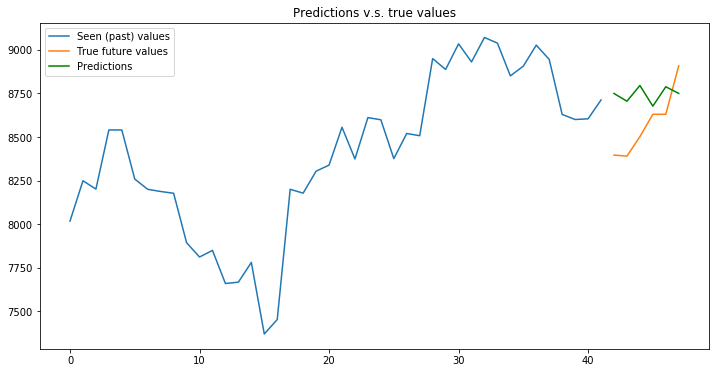

In [19]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))
X, Y = dataloader.generate_data_keras_batch(isTrain=False, batch_size=nb_predictions)
print(X.shape, Y.shape)
#outputs = model.predict(X.reshape(-1,288,17), batch_size=5, verbose=1)
outputs = model.predict(X, batch_size=1, verbose=1)
#outputs = outputs.reshape(48,-1,1)
#feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
#outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print('outputs_shape', outputs.shape)


for j in range(nb_predictions): 
    plt.figure(figsize=(12, 6))
    
    for k in range(out_dim):
        past = X[j,:,k]
        expected = Y[j,:,k]
        #pred = outputs[j,:,k]
        pred = outputs[j,:]
        
        if pct:
            expected = inverse_pct(past[-1], expected)
            pred = inverse_pct(past[-1], pred)
        
        dataloader.denormalize_1d(past, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(expected, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(pred, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        
        print("Test mse is: ", np.mean((pred - expected)**2))
        
        print(past.shape, expected.shape, pred.shape)
        #print(pred)
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "g", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()


In [16]:
total_mse = []
scaled_mse = []
correct = []
sign = []
correct_total = {}
sign_total = {}
random_guess = {}

In [17]:
# Test
nb_predictions = 512
for i in range(25):
    X, Y = dataloader.generate_data_keras_batch(isTrain=False, batch_size=nb_predictions)
    outputs = model.predict(X, batch_size=32, verbose=0)
    for j in range(nb_predictions): 
        
        for k in range(out_dim):
            past = X[j,:,k]
            expected = Y[j,:,k]
            #pred = outputs[j,:,k]
            pred = outputs[j,:]

             
            
            if pct:
                expected = inverse_pct(past[-1], expected)
                pred = inverse_pct(past[-1], pred)

            s_mse = np.mean((pred - expected)**2)
            dataloader.denormalize_1d(past, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
            dataloader.denormalize_1d(expected, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
            dataloader.denormalize_1d(pred, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
            mse = np.mean((pred - expected)**2)
            
            rnd = np.random.rand(out_len, 1)

            for step in range(out_len):
                p_sign = np.sign(pred[step] - past[-1])
                # check if there is bias in price movement
                if step not in sign_total:
                    sign_total[step] = [p_sign]
                else:
                    sign_total[step].append(p_sign)
                    
                if step not in random_guess:
                    random_guess[step] = rnd[step]
                else:
                    random_guess[step] = 0
                
                # accuracy measure - for every timestep in output, check if price moved up/down in expected way
                # compared to last price of input
                # if sign of expected - input == predicted - input is same, then we got it right
                corr = 0
                if np.sign(expected[step]-past[-1]) == np.sign(pred[step] - past[-1]):
                    corr = 1
                    
                if step not in correct_total:
                    correct_total[step] = [corr]
                else:
                    correct_total[step].append(corr)
                           
            prediction_sign = np.sign(pred[-1] - past[-1])

            if np.sign(expected[-1]-past[-1]) == np.sign(pred[-1] - past[-1]):
                correct.append(1)
            else:
                correct.append(0)
                
            sign.append(prediction_sign)
            total_mse.append(mse)
            scaled_mse.append(s_mse)
            #print(past.shape, expected.shape, pred.shape)

print('Average Scaled MSE:', np.mean(scaled_mse))  
print('Average MSE:', np.mean(total_mse))    
print('Percent of successful predictions:', np.mean(correct))
print('Average sign of predictions:', np.mean(sign))
print('RMSE')
print(pd.DataFrame(np.sqrt(total_mse)).describe())

Average Scaled MSE: 0.00036895560783467297
Average MSE: 139096.08763612597
Percent of successful predictions: 0.63671875
Average sign of predictions: 0.55859375
RMSE
                  0
count  12800.000000
mean     320.506045
std      190.721799
min       61.681005
25%      168.659661
50%      259.800087
75%      429.478594
max      978.015879


In [18]:
for i in range(out_len):
    print('Percent of successful predictions for', i+1, ':', np.mean(correct_total[i]), '; sign: ', np.mean(sign_total[i]))

Percent of successful predictions for 1 : 0.559921875 ; sign:  0.56796875
Percent of successful predictions for 2 : 0.547734375 ; sign:  0.38953125
Percent of successful predictions for 3 : 0.53859375 ; sign:  0.63953125
Percent of successful predictions for 4 : 0.58375 ; sign:  0.37578125
Percent of successful predictions for 5 : 0.532265625 ; sign:  0.67296875
Percent of successful predictions for 6 : 0.63671875 ; sign:  0.55859375


In [22]:
print(pd.DataFrame(np.sqrt(total_mse)).describe())

                 0
count  4000.000000
mean    543.843081
std     331.773402
min     218.541946
25%     297.502933
50%     392.623727
75%     692.623447
max    1561.881972
